In [2]:
import torch
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
# DAE_np_data_path = r'C:\Users\lastrand\Python\MCML\data\np\13516002.csv'
DAE_np_data_path = r'C:\Users\lastrand\Python\MCML\data\np\X4sShowX4StdOut.csv'

np_DAE_df = pd.read_csv(DAE_np_data_path)

In [28]:
# A dataset of 
np_DAE_df[np_DAE_df['author1'] != 'K.H.Hicks+'] # Dataset has multiple authors, we keep only B.K.Park+ to ensure only one target material...

,DatasetID,year1,author1,y:Value,y,dy,x1:ResEn,x1(eV),dx1(eV),x2:IncEn,...,Proj,Emiss,Prod1,MF,MT,ReacType,Quant1,nx,indVars,Reacode
205,13530002,1993,B.K.Park+,Data(B/SR/EV),2.332000e-07,6.086000e-08,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"
206,13530002,1993,B.K.Park+,Data(B/SR/EV),1.133000e-07,4.229000e-08,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"
207,13530002,1993,B.K.Park+,Data(B/SR/EV),8.373000e-08,3.650000e-08,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"
208,13530002,1993,B.K.Park+,Data(B/SR/EV),0.000000e+00,0.000000e+00,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"
209,13530002,1993,B.K.Park+,Data(B/SR/EV),3.774000e-07,7.774000e-08,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13552,13530013,1993,B.K.Park+,Data(B/SR/EV),6.241000e-07,1.777000e-07,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"
13553,13530013,1993,B.K.Park+,Data(B/SR/EV),7.420000e-07,1.948000e-07,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"
13554,13530013,1993,B.K.Park+,Data(B/SR/EV),6.237000e-07,1.786000e-07,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"
13555,13530013,1993,B.K.Park+,Data(B/SR/EV),1.247000e-06,2.536000e-07,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"


In [ ]:
df = np_DAE_df[['x2(eV)', 'x3(eV)', 'x4(deg)','y', 'dy']]

df = df.rename(columns={
    'x2(eV)': 'E_inc',
    'x3(eV)': 'E_sec',
    'x4(deg)': 'theta',
    'y': 'ddcs',  # double differential cross section
    'dy': 'Errddcs'  # Error on double differential cross section --> Could use this to weigh the KL loss (IDEA)

})

df['E_inc'] = df['E_inc'] / 1e6  # eV → MeV
df['E_sec'] = df['E_sec'] / 1e6  # eV → MeV

# Drop rows with missing values
df = df.dropna(subset=['E_inc', 'E_sec', 'theta', 'ddcs'])



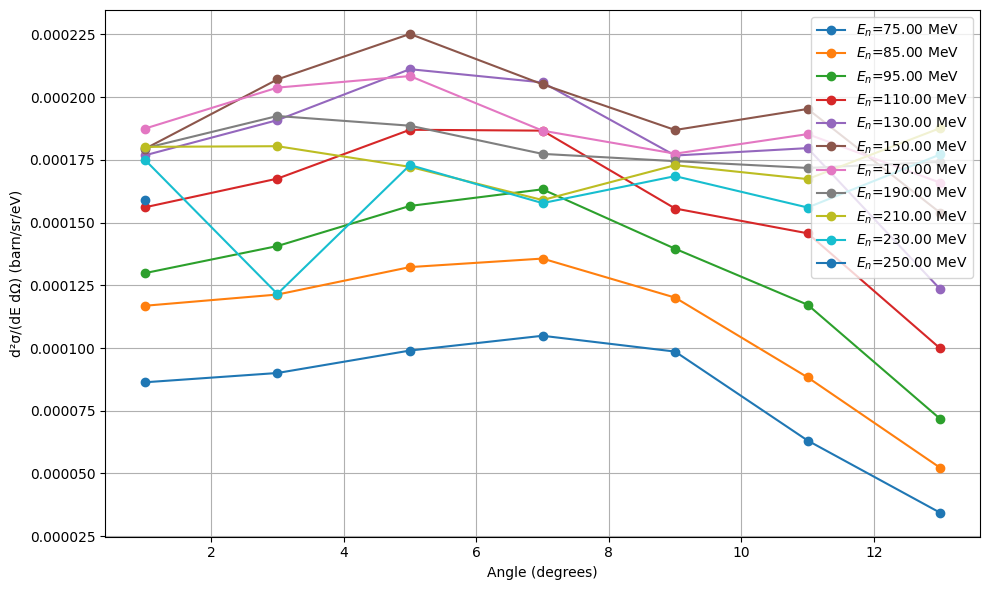

In [27]:
angle_max = np.max(df['theta'].unique())
unique_angles = np.sort(df['theta'].unique())

# energies_to_plot = np.linspace(df['E_inc'].min(), df['E_inc'].max(), 10)  # 10 evenly spaced energies
energies_to_plot = df['E_inc'].unique()
tolerance = 0.05  # MeV

plt.figure(figsize=(10, 6))

for E_n in energies_to_plot:
    if E_n in (65,298):
        continue
    
    df_slice = df[np.abs(df['E_inc'] - E_n) < tolerance] 
    if df_slice.empty:
        continue
    
    # grouped = df_slice.groupby('theta')['ddcs'].sum()
    # # Align grouped with full angle range
    # y_vals = np.array([grouped.get(angle) for angle in unique_angles])
    
    # plt.plot(unique_angles, y_vals, marker='o', label=rf"$E_n$={E_n:.2f} MeV")
    grouped = df_slice.groupby('theta')['ddcs'].sum()
    angles_present = grouped.index.to_numpy()
    y_vals = grouped.to_numpy()

    plt.plot(angles_present, y_vals, marker='o', label=rf"$E_n$={E_n:.2f} MeV")

plt.xlabel("Angle (degrees)")
plt.ylabel("d²σ/(dE dΩ) (barn/sr/eV)")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
# plt.yscale('log')  # optional log scale for better visibility
plt.show()
